# Setup

In [54]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras import optimizers
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ETree
from pathlib import Path
import cv2
import os
import matplotlib.pyplot as plt
from google.colab import drive
import skimage
from skimage import io, transform
import matplotlib.patches as patches

# Preprocessing

In [14]:
def generate_annotations_data(annotation_path,image_path):
  annotations_list = []
  
  for annot_file in annotation_path.iterdir():
    root = ETree.parse(annot_file).getroot()
    
    #creating dictionary of image attributed (and bounding box details)
    annot = {}
    annot['image_file'] = Path(str(image_path)+'/'+ root.find("./filename").text)
    annot['width'] = root.find("./size/width").text
    annot['height'] = root.find("./size/height").text
    annot['class'] = root.find("./object/name").text
    
    #extracting bbox details
    signs = root.findall("./object")
    
    if (len(signs)>1):
      x_mins = []; x_maxs = []; y_mins = []; y_maxs = []
      
      for sign in signs:
        x_mins.append(sign.find("./bndbox/xmin").text)
        x_maxs.append(sign.find("./bndbox/xmax").text)
        y_mins.append(sign.find("./bndbox/ymin").text)
        y_maxs.append(sign.find("./bndbox/ymax").text)
        
      annot['num_obj'] = len(x_mins)
      annot['xmin'] = x_mins
      annot['xmax'] = x_maxs
      annot['ymin'] = y_mins
      annot['ymax'] = y_maxs  

    else:
      annot['num_obj'] = 1
      annot['xmin'] = root.find("./object/bndbox/xmin").text
      annot['xmax'] = root.find("./object/bndbox/xmax").text
      annot['ymin'] = root.find("./object/bndbox/ymin").text
      annot['ymax'] = root.find("./object/bndbox/ymax").text

    annotations_list.append(annot)

  training_dataframe = pd.DataFrame(annotations_list)

  return training_dataframe

def read_image(path):
    '''
    Inputs:
      path: filepath to particular image
    
    Output: 3D numpy array of pixel values in RGB (width, height, channels) 
    '''
    #given a particular filepath to the image, converts the image to np array pixel values (in RGB format)
    image = cv2.imread(str(path))
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
def extract_bbox_coor(df_row):
    '''
    Inputs:
      df_row: single row of dataframe i.e. containing all coordinates of bbox

    Output: np array of (xmin, xmax, ymin, ymax) of bbox
    '''

    if (df_row['num_obj']==1):
      #given a row of the PD dataframe, extracts the bbox coordinates
      return np.array([df_row['xmin'],df_row['xmax'],df_row['ymin'],df_row['ymax']], dtype=np.int)
    
    elif (df_row['num_obj']==0):
      return np.zeros((4), dtype=np.int)

    else:
      
      bbox_coor = []

      for i in range(df_row['num_obj']):
        bbox_coor.append( [ df_row['xmin'][i],df_row['xmax'][i],df_row['ymin'][i],df_row['ymax'][i] ] )
      
      return np.array(bbox_coor, dtype=np.int)



def overlay_mask(bbox, img):
  '''
  Inputs:
    bbox: array of bbox coordinates [output of extract_bbox_coor] (xmin, xmax, ymin, ymax)
    img: 3D numpy array of pixel values [output of read_image] (height, width, channels)
  
  Output: 2D np array containing 1s within bbox region
  '''

  rows,cols,__ = img.shape #take rows and columns, ignoring depth

  bbox = bbox.astype(np.int)
  bbox_mask = np.zeros((rows,cols))

  if (len(bbox.shape)>1): #multiple bboxes present
    for box in bbox:
      bbox_mask[box[2]:box[3], box[0]:box[1]] = 1 #mask region containing bbox convert to all 1s (object present)

  elif (len(bbox.shape)==0): #no bboxes present
    return bbox_mask

  else:
    bbox_mask[bbox[2]:bbox[3], bbox[0]:bbox[1]] = 1 #mask region containing bbox convert to all 1s (object present) 

  return bbox_mask

def overlay_separate_mask(bbox, img):

  rows,cols,__ = img.shape #take rows and columns ignoring depth

  bbox = bbox.astype(np.int)

  bbox_list = []

  if (len(bbox.shape)>1):
    for box in bbox:
        bbox_separate_mask = np.zeros((rows,cols))
        bbox_separate_mask[box[2]:box[3], box[0]:box[1]]= 1 #mask regions containing bbox (separate for each box present)
        bbox_list.append(bbox_separate_mask)

  return bbox_list


def mask_to_bbox(mask_resized, num_sign, separate_masks_list, img_size):
  '''
  Inputs:
    mask_array: AFTER RESIZING image, need to find new coordinates of BBox
    num_sign: number of objects (signs) in the particular image - account for different cases
  
  Output: np array of float32 indicating new bbox coordinates [xmin, xmax, ymin, ymax]
  '''
  rows, cols = np.nonzero(mask_resized)

  assert(num_sign>0)

  if (num_sign==1):
    xmin = min(cols)
    xmax = max(cols)

    ymin = min(rows)
    ymax = max(rows)
    
    return np.array([xmin, xmax, ymin, ymax], dtype=np.float32)
  
  elif (num_sign==0):
    return np.zeros(4, dtype=nnp.float32)
  
  else:
    all_bboxes = []
    for mask_array in separate_masks_list:
      mask_array = cv2.resize(mask_array,( img_size[0], img_size[1] ))
      rows, cols = np.nonzero(mask_array)

      xmin = min(cols); xmax = max(cols)
      ymin = min(rows); ymax = max(rows)

      assert(ymin<ymax) #error-checking that coordinates meet requirements
      assert(xmin<xmax)
      all_bboxes.append([ymin, xmin, ymax, xmax])

    
    return np.array(all_bboxes, dtype=np.float32)

def resize_images_and_bbox(read_filepath, img_write_filepath, mask_write_filepath, num_obj, bbox_coor, img_size=(400,400), save=False):
  '''
  Inputs:
    read_filepath: filepath to image to be resized
    write_filepath: filepath to which resized image should be saved

    bbox_coor: output of extract_bbox_coor (bounding box coordinates in [xmin, xmax, ymin, ymax])
    img_size: tuple containing (height, width) of resized image standard

  '''

  image_pixels = read_image(read_filepath) #outputs 2D numpy array of pixel values

  image_pixels_resized = cv2.resize(image_pixels,( img_size[0], img_size[1] ))
  mask_resized = cv2.resize( overlay_mask(bbox_coor, image_pixels),  ( img_size[0], img_size[1] )   )

  separate_masks_list = overlay_separate_mask(bbox_coor,image_pixels)
  
  save_img_path = str(img_write_filepath/read_filepath.parts[-1]) #extracting the last segment of the read in data path (file name) and adding to the write path
  save_mask_path = str(mask_write_filepath/read_filepath.parts[-1])
  
  if (save==True):
    cv2.imwrite(save_img_path, cv2.cvtColor(image_pixels_resized, cv2.COLOR_RGB2BGR))
    plt.imshow(mask_resized,cmap='gray')
    plt.savefig(save_mask_path)
  

  return save_img_path, mask_to_bbox(mask_resized, num_obj, separate_masks_list, img_size)

# MultiLayerCNN

In [15]:
class MultiLayerCNN():
  def __init__(self, weight_regularizer):
    self.reg = tf.keras.regularizers.L2(l2=weight_regularizer)

    self.conv1 = tf.keras.layers.Conv2D(filters = 96, kernel_size = 8, strides = (1,1),padding = 'VALID', activation = 'relu',name = 'conv1', use_bias = True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01), bias_initializer=tf.keras.initializers.Ones(),kernel_regularizer=self.reg, bias_regularizer=self.reg)
    self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=1)
    self.conv2 = tf.keras.layers.Conv2D(filters = 256, kernel_size = 5, strides = (1,1),padding = 'VALID', activation = 'relu',name = 'conv2', use_bias = True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01), bias_initializer=tf.keras.initializers.Ones(),kernel_regularizer=self.reg, bias_regularizer=self.reg)
    self.pool2 = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=2)
    self.conv3 = tf.keras.layers.Conv2D(filters = 384, kernel_size = 3, strides = (1,1),padding = 'VALID', activation = 'relu',name = 'conv3', use_bias = True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01), bias_initializer=tf.keras.initializers.Constant(value=0.1),kernel_regularizer=self.reg, bias_regularizer=self.reg)
    self.conv4 = tf.keras.layers.Conv2D(filters = 384, kernel_size = 3, strides = (1,1),padding = 'VALID', activation = 'relu',name = 'conv4', use_bias = True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01), bias_initializer=tf.keras.initializers.Constant(value=0.1),kernel_regularizer=self.reg, bias_regularizer=self.reg)
    self.conv5 = tf.keras.layers.Conv2D(filters = 384, kernel_size = 3, strides = (1,1),padding = 'VALID', activation = 'relu',name = 'conv5', use_bias = True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01), bias_initializer=tf.keras.initializers.Constant(value=0.1),kernel_regularizer=self.reg, bias_regularizer=self.reg)
    self.pool3 = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=2)
    self.conv6 = tf.keras.layers.Conv2D(filters = 1024, kernel_size = 6, strides = (2,2),padding = 'VALID', activation = 'relu',name = 'conv6', use_bias = True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01), bias_initializer=tf.keras.initializers.Constant(value=1),kernel_regularizer=self.reg, bias_regularizer=self.reg)
    self.dropout1 = tf.keras.layers.Dropout(rate = 0.5)

  def call(self, inputs):
    layer1 = tf.pad(inputs, [[0,0],[2,2],[2,2],[0,0]])
    layer1 = self.conv1(layer1)
    layer1 = tf.nn.local_response_normalization(layer1, depth_radius=5, bias=2, alpha=0.0005, beta=0.75)
    layer1 = self.pool1(layer1)
    layer2 = tf.pad(layer1, [[0,0],[2,2],[2,2],[0,0]])
    layer2 = self.conv2(layer2)
    layer2 = tf.nn.local_response_normalization(layer1, depth_radius=5, bias=8, alpha=0.0005, beta=0.75)
    layer2 = self.pool2(layer2)
    layer3 = tf.pad(layer2, [[0,0],[1,1],[1,1],[0,0]])
    layer3 = self.conv3(layer3)
    layer4 = tf.pad(layer3, [[0,0],[1,1],[1,1],[0,0]])
    layer4 = self.conv4(layer4)
    layer5 = tf.pad(layer4, [[0,0],[1,1],[1,1],[0,0]])
    layer5 = self.conv5(layer5)
    layer5 = self.pool3(layer5)
    layer6 = tf.pad(layer5, [[0,0],[3,3],[3,3],[0,0]])
    layer6 = self.conv6(layer6)
    layer6 = self.dropout1(layer6)

    return layer6

# FasterRCNN

In [34]:
class AnchorBox_Extractor_and_Setup():

  def __init__(self):
    
    self.img_size = 400
    self.subsampling_size = 8
    self.feat_map_size = self.img_size//self.subsampling_size
    #for an image of 400x400 --> sampling of 8x8 ---> gives 50x50 feature map i.e. each feature map pixel corresp. to a 16x16 sample
    
    #Loss Sample Hyperparameters
    self.pos_ratio = 0.5
    self.loss_sample = 256.0 #sampling 256 labels randomly

    #Define 3 scales and aspect ratios (for anchor boxes) on each pixel on 50x50 feature map
    self.anchor_scales = [16.0, 32.0]
    self.anchor_aspect_ratios = [1.0, 2.0]

    self.pos_IoU_threshold = 0.7  #Consider 'objectness' true: 1
    self.neg_IoU_threshold = 0.3  #Consider 'objectness' false: 0

    #Centers of Anchor Points (in 50x50 feature map)
    self.centers = tf.zeros((tf.math.square(self.feat_map_size),2), dtype = tf.float32 )

    #Tensor containing all 9 anchor box coordinates for each pixel (sub sample) of the 50x50 feature map
    self.anchor_boxes = tf.zeros( (tf.math.square(self.feat_map_size)*len(self.anchor_scales)*len(self.anchor_aspect_ratios),  4)     )
    # [ feat_map_size^2 * 9, 4 ] tensor => stores 4 coord (y1,x1, y2, x2) for all 9 anchorboxes on each of the 50x50 pixels in the image
    # have (feat_map_size^2 * 9 ) anchorboxes total: 9 for each pixel of feature map

    self.anchor_labels = -1*tf.ones( (len(self.anchor_boxes), ), dtype=tf.int32)

    # self.anchor_locations = tf.zeros( (len(self.anchor_boxes), 4)) #[dy,dx,dh,dw]
    #To be populated with FINAL objectness and location data (not just valid anchors)


  def generate_centers(self):
    ''' 
    Purpose:
      Given the subsample size and output feature map size, constructs a reference array of centers for a particular image

    Inputs:

      subs_size: sub-sample size (from model init) of original image for which anchor point is made

      fm_size: size of output feature map (from Conv Network) i.e. number of anchor points
    
    Output:
      N/A

    '''
    subs_size = self.subsampling_size; fm_size = self.feat_map_size

    #Generate a list of anchor point end-points i.e. ends of 8x8 subsample  
    centers_x = tf.range(subs_size, (fm_size+1)*subs_size, subs_size, dtype = tf.float32)
    centers_y = tf.range(subs_size, (fm_size+1)*subs_size, subs_size, dtype = tf.float32)

    #Offset absolute end-points of subsample to get center of subsample
    centers_x = centers_x - (subs_size/2)
    centers_y = centers_y - (subs_size/2)

    #Populating centers array
    center_one_pixel = tf.stack([centers_y,centers_x],axis = 1)
    center_picture = center_one_pixel

    for i in range(fm_size-1):
      center_picture = tf.concat([center_picture,center_one_pixel], axis = 0)
    
    self.centers = center_picture

  def construct_anchor_box_coords(self):
    subs_size = self.subsampling_size
    scales = self.anchor_scales
    aspect_ratios = self.anchor_aspect_ratios
    
    anchor_box_ws = []
    anchor_box_hs = []

    for s in scales:
        for r in aspect_ratios:

          #Total height and width of particular anchor-box, with reference to sub-sampling size
          box_h = subs_size*s*tf.math.sqrt(r)
          box_w = subs_size*s*tf.math.sqrt(1/r)

          anchor_box_ws.append(box_w)
          anchor_box_hs.append(box_h)
    
    anchor_box_ws = np.array(anchor_box_ws, dtype = np.float32)
    anchor_box_hs = np.array(anchor_box_hs, dtype = np.float32)

    anchor_box_ws = anchor_box_ws/2.0
    anchor_box_hs = anchor_box_hs/2.0

    num_boxes = len(scales)*len(aspect_ratios)

    anchor_box_computation = tf.convert_to_tensor([[0.0,0.0,0.0,0.0]], dtype = tf.float32)

    for ctr_y, ctr_x in self.centers:
      #Extracting x and y center coord

      #Constructing anchor-box coordinates (from height and width) for a single anchor in feature map (y1, x1, y2, x2)
      col0 = ctr_y - anchor_box_hs
      col1 = ctr_x - anchor_box_ws
      col2 = ctr_y + anchor_box_hs
      col3 = ctr_x + anchor_box_ws

      one_pixel = tf.stack([col0,col1,col2,col3], axis = 1)

      anchor_box_computation = tf.concat([anchor_box_computation, one_pixel], axis = 0)
    
    self.anchor_boxes = anchor_box_computation[1:]


  def bbox_area(self, ymin, xmin, ymax, xmax):

    area = (ymax-ymin)*(xmax-xmin)

    return area
  
  

  def calculate_ious_and_labels(self, ground_truth_bboxes, num_objs):
    '''
    Inputs:
      ground_truth_bboxes: (num_objs, 4) array containing coordinates of bbox ground truth as [y1, x1, y2, x2]
      num_objs: number of objects (targets) in particular image
    
    Output:
      IoU for each valid anchor box i.e. array of -1 or 1 based on objectness of anchor box

    '''


    #Create array of valid anchor boxes (contained within the image) [y1, x1, y2, x2]
    valid_idx = np.where((self.anchor_boxes[:,0]>=0) & (self.anchor_boxes[:,1]>=0)&(self.anchor_boxes[:,2]<=self.img_size)&(self.anchor_boxes[:,3]<=self.img_size) )[0]
    
    valid_anchor_boxes = tf.gather(self.anchor_boxes, valid_idx)
    anchor_box_areas = tf.math.multiply(valid_anchor_boxes[:,2]-valid_anchor_boxes[:,0],valid_anchor_boxes[:,3]-valid_anchor_boxes[:,1]) #array [len(valid_idx), 1] | (y2-y1)*(x2-x1)

    box_labels = -1*np.ones((len(valid_anchor_boxes),)) #labels for each valid anchor box (initially -1 i.e. not containing obj)


    '''Calculating IoU wrt each ground truth refernece box'''
    
    # ious = tf.zeros((self.feat_map_size*self.feat_map_size*len(self.anchor_aspect_ratios)*len(self.anchor_scales),num_objs), dtype=tf.float32).numpy() #generate IoU value for each valid anchor box + obj pairing in image
    ious = tf.zeros((len(valid_anchor_boxes),num_objs), dtype=tf.float32).numpy() #generate IoU value for each valid anchor box + obj pairing in image
    # for num1, i in enumerate(valid_anchor_boxes):
    #   ya1, xa1, ya2, xa2 = i  
    #   anchor_area = (ya2 - ya1) * (xa2 - xa1)
    #   for num2, j in enumerate(ground_truth_bboxes):
    #     yb1, xb1, yb2, xb2 = j
    #     box_area = (yb2- yb1) * (xb2 - xb1)
    #     inter_x1 = max([xb1, xa1])
    #     inter_y1 = max([yb1, ya1])
    #     inter_x2 = min([xb2, xa2])
    #     inter_y2 = min([yb2, ya2])
    #     if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
    #         iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
    #         iou = iter_area / (anchor_area+ box_area - iter_area)            
    #     else:
    #         iou = 0.0
    #     ious[num1, num2] = iou

    for id, coor in enumerate(ground_truth_bboxes):

      #Calculating area of each ground-truth box
      ygt_min, xgt_min, ygt_max, xgt_max = coor
      truth_box_area = self.bbox_area(ygt_min, xgt_min, ygt_max, xgt_max)

      ygt_min = ygt_min*(tf.ones(len(valid_idx)));  xgt_min = xgt_min*(tf.ones(len(valid_idx)));  ygt_max = ygt_max*(tf.ones(len(valid_idx))); xgt_max = xgt_max*(tf.ones(len(valid_idx)))

      #Extracting array of all valid anchor-box coordinates
      ya_min = valid_anchor_boxes[:,0]; xa_min = valid_anchor_boxes[:,1]; ya_max = valid_anchor_boxes[:,2]; xa_max = valid_anchor_boxes[:,3]


      inter_x_min = tf.math.maximum(xgt_min, xa_min); inter_y_min = tf.math.maximum(ygt_min, ya_min); inter_x_max = tf.math.minimum(xgt_max, xa_max); inter_y_max = tf.math.minimum(ygt_max, ya_max)
      inter_areas = tf.math.multiply(inter_y_max-inter_y_min, inter_x_max-inter_x_min) #area of box intersection


      valid_inter = tf.where((inter_x_min<inter_x_max) & (inter_y_min<inter_y_max))  #find valid intersection boxes
      valid_inter = tf.reshape(valid_inter, (valid_inter.shape[0],))

      for row in valid_inter:
        #Calculating IoU values for the valid intersection boxes
        IoU_val = (inter_y_max[row]-inter_y_min[row])*(inter_x_max[row]-inter_x_min[row])/(truth_box_area+anchor_box_areas[row]-inter_areas[row])
        ious[row,id] = IoU_val


    
    '''Calculating MAX IoU & setting threshold'''

    #For each ground-truth object, which anchor box has max IoU --> output (num objects) i.e. [obj1_max_anchor, obj2_max_anchor,....]
    max_anchor4gt_arg = np.argmax(ious,axis=0)
    max_IoU_gt = ious[max_anchor4gt_arg, np.arange(ious.shape[1])] 
    

    #tf.math.argmax returns FIRST MAX IoU index (across anchor boxes) for each object -> tf.where ensures to collect multiple anchor_boxes that all have max IoU
    max_anchor4gt_arg = np.where(ious == max_IoU_gt)[0]  #For EACH GT_BOX, INDEX (ANCHOR_BOX) with max IoU i.e. ANCHOR that gives MAX IoU for EACH GT_BOX --> best predictor for GT_BOX


    #For each anchor box, which ground-truth object has max IoU --> output (num valid anchor box) i.e. [anchor1_max_obj, anchor2_max_obj,....]
    max_gt4anchor_arg = np.argmax(ious, axis=1)
    max_IoU_anchor = ious[np.arange(len(valid_anchor_boxes)),max_gt4anchor_arg] #For EACH ANCHOR_BOX, max IoU for individual anchor -> compare with threshold min/max (to see which ANCHOR_BOX to take)
    

    '''
        max_gt4anchor_arg — which ground-truth object has max iou for each anchor box.
        max_IoU_anchor —  the (value of) maximum IoU associated with ground-truth object for each anchor box.
        
        max_anchor4gt_arg — which anchor box has the highest Intersection-over-Union (IoU) for each ground-truth box.
        max_IoU_gt — the (value of) maximum IoU associated with anchor box for each ground-truth box
    '''
    

    '''Objectness Labelling: Based on IoU overlap'''

    #Negative Label (0) across all anchor boxes where max_IoU is < min threshold 
    box_labels[ max_IoU_anchor < self.neg_IoU_threshold] = 0
    
    #Positive Label (1) across all anchor boxes where max_IoU if >= max threshold
    box_labels[max_IoU_anchor >= self.pos_IoU_threshold] = 1

    #Positive Label (1) for each anchor box with highest IoU with ground-truth box
    box_labels[max_anchor4gt_arg] = 1

    max_IoU_gt = tf.convert_to_tensor(max_IoU_gt)
    max_IoU_anchor = tf.convert_to_tensor(max_IoU_anchor)
    ious = tf.convert_to_tensor(ious)

      
    return box_labels, valid_anchor_boxes, max_gt4anchor_arg, valid_idx



  def extract_loss_samples(self, anchorbox_labels, valid_idx):
    '''Each mini-batch arises from a single image that contains many positive and negitive example anchors, 
    but this will bias towards negitive samples as they are dominate. Instead, we randomly sample 256 anchors 
    in an image to compute the loss function of a mini-batch, where the sampled positive and negative anchors have a ratio of up to 1:1. 
    If there are fewer than 128 positive samples in an image, we pad the mini-batch with negitive ones'''

    '''
    Input:
      anchorbox_labels: labels output from calculate_ious_and_labels i.e. the label (objectness) of each anchorbox
    
    Output:
      anchorbox_labels: modified labels containing only the randomly sampled 'positive' (1) and 'negative' (0) labels - all other labels nullified i.e. set to -1
    '''

    #Positive Samples from Labels
    num_pos_samples = int(self.loss_sample * self.pos_ratio)
    pos_indexes = np.where(anchorbox_labels==1)[0]

    if (len(pos_indexes)>num_pos_samples):
      disable_idx = tf.convert_to_tensor(np.random.choice(pos_indexes, size=len(pos_indexes)-num_pos_samples)) 
      anchorbox_labels[disable_idx] = -1 #Nullify positive samples not chosen

    #Negative Samples from Labels
    num_neg_samples = self.loss_sample * np.sum(anchorbox_labels == 1)  #int(self.loss_sample*(1-self.pos_ratio))
    neg_indexes = np.where(anchorbox_labels==0)[0]

    if (len(neg_indexes)>num_neg_samples):
      disable_idx = tf.convert_to_tensor(np.random.choice(neg_indexes, size = len(neg_indexes)-num_neg_samples ))
      anchorbox_labels[disable_idx] = -1 #Nullify negative samples not chosen
    
    anchor_labels = np.zeros((len(self.anchor_boxes),))
    anchor_labels[valid_idx] = anchorbox_labels

    anchor_labels = tf.convert_to_tensor(anchor_labels)
    
    return anchor_labels



  def assign_anchorbox_locations(self, max_gt4anchor_arg, ground_truth_bboxes, valid_anchorbox, box_labels, valid_index):
    '''
    Inputs:
      max_gt4anchor_arg: indexes of the ground-truch box that has Max IoU for each anchor box (from calculate_ious_and_labels())
      ground_truth_bboxes: (num_objs, 4) array containing coordinates of bbox ground truth as [y1, x1, y2, x2]
      valid_anchorbox: (num_valid_anchorbox, 4) array containing coordinates of each valid anchorbox on the image [y1, x1, y2, x2]
      valid_index: indexes of anchor_boxes that are within the image
    
    Output:
      Finds the dx, dy, dh, dw (i.e. deltas to each anchor box to fit the closest matching ground truth) --> serves as targets for the RPN Network (reference for loss and accuracy)
    '''

    #extract array/tensor (len(valid_anchorbox),) containing ground-truth box coordinates [for GT_BOX with MAX IOU for each anchorbox]
    max_iou_gt_boxes = tf.gather(ground_truth_bboxes,max_gt4anchor_arg)
    
    #Note: valid_anchorbox has box coordinates of the form [y1, x1, y2, x2]
    h_a = valid_anchorbox[:,2] - valid_anchorbox[:,0] #anchor box height (num_valid_anchorbox, 1)
    w_a = valid_anchorbox[:,3] - valid_anchorbox[:,1] #anchor box width  (num_valid_anchorbox, 1)
    ctr_y_a = h_a*0.5 + valid_anchorbox[:,0] #anchor box vertical center (num_valid_anchorbox, 1)
    ctr_x_a = w_a*0.5 + valid_anchorbox[:,1] #anchor box horizontal center (num_valid_anchorbox, 1)
    
    #Note: to avoid division by zero in delta computation, get the epsilon (smallest value) of tf.float32
    min_val = np.finfo(np.float32).eps
    h_a = tf.maximum(h_a,min_val); w_a = tf.maximum(w_a, min_val)

    #For each anchorbox, we have found the corresp. GT Box providing Max IoU
    h_gt_max = max_iou_gt_boxes[:,2] - max_iou_gt_boxes[:,0] # height of corresponding GT Box (with Max IoU) 
    w_gt_max = max_iou_gt_boxes[:,3] - max_iou_gt_boxes[:,1] # width of corresponding GT Box (with Max IoU)
    ctr_y_gt_max = h_gt_max*0.5 + max_iou_gt_boxes[:,0] #vertical center of corresponding GT Box (with Max IoU)
    ctr_x_gt_max = w_gt_max*0.5 + max_iou_gt_boxes[:,1] #horizontal center of corresponding GT Box (with Max IoU)


    '''
    Faster_R-CNN paper uses the following parametrizion delta outputs (based on anchor and ground-truth boxes)
      dx = (x_gt - x_{a})/w_{a}
      dy = (y_gt - y_{a})/h_{a}
      dw = log(w_gt/ w_a)
      dh = log(h_gt/ h_a)
    '''

    dx = (ctr_x_gt_max-ctr_x_a)/w_a
    dy = (ctr_y_gt_max-ctr_y_a)/h_a
    dw = tf.math.log(w_gt_max/w_a)
    dh = tf.math.log(h_gt_max/h_a)

    anchor_locs = tf.stack((dy,dx,dh,dw), axis=1) #array of deltas: (num_valid_anchors, 4 i.e. dy,dx,dh,dw)

    anchor_locations = np.zeros((len(self.anchor_boxes),4), dtype=np.float32)
    anchor_locations[valid_index, :] = anchor_locs.numpy()

    anchor_locations = tf.convert_to_tensor(anchor_locations, dtype = tf.float32)

    #FINAL Setup: Setting final anchor_labels and anchor_locations (wrt overall image) - not just the valid anchor boxes within image
    return box_labels, anchor_locations # array (num_anchor_boxes, ) and array (num_anchor_boxes, 4)  i.e. with dy, dx, dh, dw

  def call(self, ground_truth_bboxes, num_objs, first_run):
    self.generate_centers()
    self.construct_anchor_box_coords()
    box_labels, valid_anchor_boxes, max_gt4anchor_arg, valid_idx = self.calculate_ious_and_labels(ground_truth_bboxes, num_objs)
    box_labels = self.extract_loss_samples(box_labels, valid_idx)
    box_labels, anchor_locs = self.assign_anchorbox_locations(max_gt4anchor_arg, ground_truth_bboxes, valid_anchor_boxes, box_labels, valid_idx)
    return box_labels, anchor_locs, self.anchor_boxes

In [35]:
class RPN_Network(tf.keras.Model):

  def __init__(self, feature_map_size, num_scales, num_ratios, batch_size, img_size):
    super(RPN_Network, self).__init__()
    '''
    Inputs:
      feature_map_size: single feature map size from Multilayer CNN
      num_scales: the set (number) of anchor-box scales used in AnchorBox construction
      num_ratios: the set (number) of anchor-box ratios used in AnchorBox construction
    '''
    #Batch Size
    self.batch_sz = batch_size

    # Input Feature Map
    self.input_size = feature_map_size # feature map output size from Multilayer-CNN

    # First Convolution
    self.hidden_channels = 512  #Fist Conv output depth
    self.hidden_filter = 3 # First Conv filter-size

    self.hidden_padding = int((self.hidden_filter-1)/2) # First Conv padding (assuming stride is 1)

    # Anchor Boxes
    self.num_anchors = num_scales*num_ratios

    #RPN Network Layers
    '''  Note: Paper initializes these layers with zero mean & 0.01 standard deviation for weights + zeros for bias '''
    self.mean = 0; self.std_dev = 0.01

    self.conv_1 = layers.Conv2D(filters = self.hidden_channels, kernel_size = self.hidden_filter, strides = (1,1), padding='SAME', kernel_initializer=initializers.RandomNormal(self.mean, self.std_dev), bias_initializer = 'zeros' )

    #regressor and classification simulate fully connected layers [1x1 filters] (with convolutions)
    self.bbox_regression_layer = layers.Conv2D(filters = self.num_anchors*4, kernel_size=1, strides=(1,1), padding='SAME', kernel_initializer=initializers.RandomNormal(self.mean, self.std_dev), bias_initializer='zeros')
    #Note: num_anchors*2 refers to '2' classes on objectness i.e. is an object or not an object
    self.classification_layer = layers.Conv2D(filters = self.num_anchors*2, kernel_size=1, strides=(1,1), padding='SAME', kernel_initializer=initializers.RandomNormal(self.mean, self.std_dev), bias_initializer='zeros', activation='softmax')


    #----------------------------- Region Proposal & Non-Max Supression----------------------------------#
    self.nms_iou_threshold = 0.7  #overlap threshold required for combining 2 or more region proposals

    self.num_box_pre_nms_train = 12000 #number of bboxes to apply (top N bbox predictions) before NMS
    self.num_box_post_nms_train = 2000 #number of bboxes NMS reduces (the N bbox predictions) to

    self.num_box_pre_nms_test = 6000
    self.num_box_post_nms_test = 500

    self.min_size = 8 #minimum bbox size (length and width) required to consider/make a valid proposals
    #Note: paper found using min. bbox size of the subsampling size (in AnchorBox Setup) worked best i.e. proposals within the subsample were invalid

    self.img_size = img_size

  def call(self, feature_maps):
    '''
    Inputs:
      feature_maps: feature maps [from Multilayer CNN] for a batch
    '''

    conv_output = self.conv_1(feature_maps)

    predicted_anchor_locs = self.bbox_regression_layer(conv_output) #Bounding Box Regression: outputs (batch_sz, 36, 50, 50) i.e. assumed dy, dx, dh, dw
    predicted_anchor_class = self.classification_layer(conv_output) #Class Prediction: outputs (batch_sz, 50, 50, 18) i.e. +ve class (1) or -ve class (0)

    predicted_anchor_locs = tf.transpose(predicted_anchor_locs, perm=[0,2,3,1]) #Reshape Bounding Box Regression: (batch_sz, 50, 50, 9*4)
    predicted_anchor_locs = tf.reshape(predicted_anchor_locs, (self.batch_sz,self.num_anchors*tf.math.square(self.input_size),4)) #Second Reshape Bounding Box Regression (batch_sz, 9*50^2, 4) i.e. (batch_sz,num_anchor_boxes,coordinates)

    predicted_anchor_class = tf.transpose(predicted_anchor_class, perm=[0,2,3,1]) #Reshape Class Prediction: outputs (batch_sz, 50, 50, 9*2)
    
    objectness_score = tf.squeeze(tf.reshape(predicted_anchor_class,(self.batch_sz,self.input_size, self.input_size, self.num_anchors,2 ))[:,:,:,:,1]) #outputs (batch_sz, 50, 50, 9)
    objectness_score = tf.reshape(objectness_score, (self.batch_sz, self.num_anchors*tf.math.square(self.input_size))) #outputs (batch_sz, 9*50^2)

    predicted_anchor_class = tf.reshape(predicted_anchor_class, (self.batch_sz, self.num_anchors*tf.math.square(self.input_size), 2)) #outputs (batch_sz, 9*50^2, 2)
    '''
    Note:
      predicted_anchor_class & predicted_anchor_locs -> outputs of RPN Network + losses to update weights
      predicted_anchor_class & objectness_score -> outputs of RPN network to proposal (NMS) layer --> input into RoI pooling & FastRCNN
    '''

    return predicted_anchor_locs, predicted_anchor_class, objectness_score
  
  def proposal_generation_layer(self, predicted_anchor_locs, objectness_scores, anchor_boxes, training=True):
    ''' 
    Region Proposals from RPN Layer have significant overlap and redundancies
    This layer performs NMS (non-max supression) based on classification scores and overlap of proposed bboxes. Used to significantly scale down the number of proposals from 22500 proposals to 2000 proposals
        
    Inputs:
      anchor_boxes -> collection of anchor_box coordinates size [feat_map_size^2 * 9, 4] + format (y1,x1, y2, x2) in Anchor_Box_Extractor_and_Setup class self.anchor_boxes
      
      objectness_scores -> objectness score for all predicted anchor box in a batch | output from call() size: (batch_sz, 9*50^2)
    '''

        
    ''' 
    Formula to convert to bbox coordinate format
      pred_ctr_x = (w_{a} * dx_{p}) + ctr_x_{a}
      pred_ctr_y = (h_{a} * dy_{p}) + ctr_x_{a}
      pred_h = np.exp(dh_{p}) * h_{a}
      pred_w = np.exp(dw_{p}) * w_{a} 

    Note: 'p' denotes "prediction" deltas | 'a' denotes raw/reference "anchor box" coordinates/height/width
    ''' 
    #anchor_boxes for a batch is size [batch_sz, 50^2*9, 4]

    #Convert (reference) anchor_box coordinates from (y1, x1, y2, x2) format to (ctr_y, ctr_x, h, w) format
    anchor_height = anchor_boxes[:,:,2]-anchor_boxes[:,:,0]
    anchor_width = anchor_boxes[:,:,3]-anchor_boxes[:,:,1]

    anchor_ctr_y = anchor_height*0.5 + anchor_boxes[:,:,0]
    anchor_ctr_x = anchor_width*0.5 + anchor_boxes[:,:,1]
    

    #The predicted_anchor_locs have locations specified as (batch_sz, 9*50^2, 4) with (dy, dx, dh, dw) coord. format --> convert to (pred_ctr_y, pred_ctr_x, pred_h, pred_w) coord. format
    #This process un-parametrizes the 'delta' outputs from RPN and offsets the coordinates from the reference anchors [using formulas above in the paper]
    pred_dy = np.squeeze(predicted_anchor_locs[:,:,0::4], axis = 2) #extracting all dy (batch_sz, 9*50^2)
    pred_dx = np.squeeze(predicted_anchor_locs[:,:,1::4], axis = 2) #extracting all dx (batch_sz, 9*50^2)
    pred_dh = np.squeeze(predicted_anchor_locs[:,:,2::4], axis = 2) #extracting all dh (batch_sz, 9*50^2)
    pred_dw = np.squeeze(predicted_anchor_locs[:,:,3::4], axis = 2) #extracting all dw (batch_sz, 9*50^2)


    #Outputting final predicted bboxes, using delta outputs from RPN wrt the reference anchor boxes
    pred_ctr_y = (anchor_height * pred_dy) + anchor_ctr_y
    pred_ctr_x = (anchor_width * pred_dx) + anchor_ctr_x
    pred_h = (tf.exp(pred_dh) * anchor_height)
    pred_w = (tf.exp(pred_dw) * anchor_width)

    pred_ctr_y = tf.expand_dims(pred_ctr_y, axis = -1)
    pred_ctr_x = tf.expand_dims(pred_ctr_x, axis = -1)
    pred_h = tf.expand_dims(pred_h, axis = -1)
    pred_w = tf.expand_dims(pred_w, axis = -1)

    #Convert predicted bboxes (in [y, x, h, w] format) to [y1, x1, y2, x2] format
    shape = predicted_anchor_locs.shape
    rois = np.zeros(shape, dtype=np.float32)    #size: (batch_sz, 9*50^2, 4)
    rois[:,:,0::4] = pred_ctr_y-0.5*pred_h
    rois[:,:,1::4] = pred_ctr_x-0.5*pred_w
    rois[:,:,2::4] = pred_ctr_y+0.5*pred_h
    rois[:,:,3::4] = pred_ctr_x+0.5*pred_w

    rois = tf.convert_to_tensor(rois)


    #------Preparing the Predicted ROIs ------#

    #Step 1: Clipping predicted ROIs to the image i.e. if predicted coordinates are <0 ==> 0 or >img_size ==> img_size
    rois = tf.clip_by_value(rois, 0, self.img_size)

    #Step 2: Remove predicted boxes with either height or width < threshold
    temp_h = rois[:,:,2]-rois[:,:,0] #size: (batch_sz, 9*50^2)
    temp_w = rois[:,:,3]-rois[:,:,1] #size: (batch_sz, 9*50^2)

    temp_h = temp_h.numpy()
    temp_w = temp_w.numpy()

    over_min = np.where((temp_h >= self.min_size) & (temp_w >= self.min_size))

    rois = rois.numpy()
    objectness_scores = objectness_scores.numpy()

    rois = rois[:,over_min[1],:] #extracting rois with >= minimum size
    
    scores = objectness_scores[:,over_min[1]] #extracting object scores for rois with >= minimum size


    #Step 3: Order (proposal and score) pairings by objectness score (in descending order) + filter the top-N proposals 
    #[ objectness score: (batch_sz, 9*50^2) and region proposal: (batch_sz, 9*50^2, 4)]
    pre_nms_topN = self.num_box_pre_nms_train if training==True else self.num_box_pre_nms_test
    
    #scores = tf.sort(scores, axis=1, direction='DESCENDING')
    #scores = scores[:,:pre_nms_topN] #extracting the top (ordered) 'N' objectness scores (across the batch)

    order = tf.argsort(scores, axis=1, direction='DESCENDING') #each row contains descending-index of objectness scores (across all anchor boxes) for a given image (batch_sz, 9*50^2)
    order = order[:,:pre_nms_topN] # shape: (batch_sz, pre_nms_topN)


    #obtaining the [top N] RoI predictions for each image | shape: (batch_sz, pre_nms_topN, 4)

    rois = tf.convert_to_tensor(rois)
    scores = tf.convert_to_tensor(scores)

    return rois, scores, order

  def apply_non_max_suppresion(self, rois, scores, order, training=True):
   
    post_nms_topN = self.num_box_post_nms_train if training==True else self.num_box_post_nms_train

    y1 = rois[:,:,0]; x1 = rois[:,:,1]
    y2 = rois[:,:,2]; x2 = rois[:,:,3] #each have size: (batch_sz, pre_nms_topN)
    
    roi_areas = tf.math.multiply((x2-x1+1),(y2-y1+1)) # roi_areas -> size: (batch_sz, pre_nms_topN,1) [areas for each RoI in the batch]
    roi_areas = roi_areas.numpy()

    #Temporary numpy conversion so that indexing assignment can be done
    rois = rois.numpy()  # rois size: (batch_sz, 9*50^2, 4)
    scores = scores.numpy() # scores size: (batch_sz, 9*50^2, 1)
    y1 = y1.numpy()
    y2 = y2.numpy()
    x1 = x1.numpy()
    x2 = x2.numpy()

    #final_idx = []
    final_rois = []
    final_scores = []

    for i, img_idx_order in enumerate(order): #img_idx_order -> size: (pre_nms_topN, ) for a given image in the batch
        choose = [] #final 2D list accumulating top 'N' post-nms indexes for each image
        img_idx_order = img_idx_order.numpy()

        while len(choose) < post_nms_topN and len(img_idx_order) > 0:

          id = img_idx_order[0] #index of RoI with maximum objectness is first in the order matrix 
          choose.append(id)

          #Finding coordinates of intersection (wrt RoI with max objectness) for all other RoIs -> to remove overlaps
          over_x1 = tf.maximum(x1[i,id],x1[i,img_idx_order[1:]])
          over_y1 = tf.maximum(y1[i,id], y1[i, img_idx_order[1:]])
          over_x2 = tf.minimum(x2[i,id], x2[i, img_idx_order[1:]])
          over_y2 = tf.minimum(y2[i,id], y2[i,img_idx_order[1:]])

          over_w = tf.maximum(0.0, over_x2-over_x1+1)
          over_h = tf.maximum(0.0, over_y2-over_y1+1)
          intersection = tf.math.multiply(over_w,over_h)

          IoU_overlap = tf.math.divide(intersection, roi_areas[i,id] + roi_areas[i,img_idx_order[1:]] - intersection) #IoU_overlap --> size: (pre_nms_topN, )

          accept_id = np.where(IoU_overlap<=self.nms_iou_threshold)[0] #only selecting those RoIs, for a given image in the batch, where IoU overlap with other RoIs is within a threshold

          img_idx_order = img_idx_order[accept_id+1] #filtering ids (for single image in batch) to those with small overlap

        if len(choose) > post_nms_topN:
          choose = choose[:post_nms_topN]

        #final_idx.append(choose) #appending list of indexes to final list (for the batch)
        final_rois.append(rois[i,choose,:])
        final_scores.append(scores[i,choose])


    rois = tf.convert_to_tensor(final_rois)
    scores = tf.convert_to_tensor(final_scores)
    
    # assert(rois.shape[1]==post_nms_topN)
    # assert(scores.shape[1]==post_nms_topN)

    return rois, scores #returns the FINAL 2000 proposals after NMS
''' 
convert the loc predictions from the rpn network to bbox [y1, x1, y2, x2] format.
clip the predicted boxes to the image
Remove predicted boxes with either height or width < threshold (min_size).
Sort all (proposal, score) pairs by score from highest to lowest.
Take top pre_nms_topN (e.g. 12000 while training and 300 while testing).
Apply nms threshold > 0.7
Take top pos_nms_topN (e.g. 2000 while training and 300 while testing)

'''

' \nconvert the loc predictions from the rpn network to bbox [y1, x1, y2, x2] format.\nclip the predicted boxes to the image\nRemove predicted boxes with either height or width < threshold (min_size).\nSort all (proposal, score) pairs by score from highest to lowest.\nTake top pre_nms_topN (e.g. 12000 while training and 300 while testing).\nApply nms threshold > 0.7\nTake top pos_nms_topN (e.g. 2000 while training and 300 while testing)\n\n'

In [36]:
class ProposalTargetsLayer():
    def __init__(self,list_of_possible_labels,batch_size, **kwargs):
      super(ProposalTargetsLayer, self).__init__()
      self.n_sample = 128
      self.pos_ratio = 0.25
      self.pos_iou_thresh = 0.5
      self.neg_iou_thresh_hi = 0.5
      self.neg_iou_thresh_lo = 0.0
      self.list_of_possible_labels = np.asarray(list_of_possible_labels)
      self.batch_size = batch_size
    
    # Takes in roi of a batch
    def call(self, rois, ground_truth_bboxes):
      gt_roi_locs_batch =[]
      gt_roi_labels_batch =[]
      sample_roi_batch=[]


      for img_num,roi in enumerate(rois):
        ious = tf.zeros((rois.shape[1], len(self.list_of_possible_labels)), dtype=tf.float32)
        ious = ious.numpy()
        roi = roi.numpy()
        for num1, i in enumerate(roi):
          ya1, xa1, ya2, xa2 = i  
          anchor_area = (ya2 - ya1) * (xa2 - xa1)
          for num2, j in enumerate(ground_truth_bboxes[img_num]):
            yb1, xb1, yb2, xb2 = j
            box_area = (yb2- yb1) * (xb2 - xb1)
            inter_x1 = max([xb1, xa1])
            inter_y1 = max([yb1, ya1])
            inter_x2 = min([xb2, xa2])
            inter_y2 = min([yb2, ya2])
            if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
              iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
              iou = iter_area / (anchor_area + box_area - iter_area)            
            else:
              iou = 0.
            ious[num1, num2] = iou
        
        gt_assignment = ious.argmax(axis = 1)
        max_iou = ious.max(axis = 1)
        gt_roi_label = self.list_of_possible_labels[gt_assignment]
        pos_index = np.where(max_iou >= self.pos_iou_thresh)[0]
        pos_roi_per_this_image = int(min(self.n_sample * self.pos_ratio, pos_index.size))

        if pos_index.size > 0:
          pos_index = np.random.choice(pos_index, size = pos_roi_per_this_image, replace=False)
         
        neg_index = np.where((max_iou < self.neg_iou_thresh_hi) &  (max_iou >= self.neg_iou_thresh_lo))[0]
        neg_roi_per_this_image = self.n_sample - pos_roi_per_this_image
        neg_roi_per_this_image = int(min(neg_roi_per_this_image, neg_index.size))
        if  neg_index.size > 0 :
          neg_index = np.random.choice(neg_index, size=neg_roi_per_this_image, replace=False)
        keep_index = np.append(pos_index, neg_index)
        gt_roi_labels = gt_roi_label[keep_index]
        gt_roi_labels[pos_roi_per_this_image:] = 0
        sample_roi = roi[keep_index]

        bbox_for_sampled_roi = ground_truth_bboxes[img_num][gt_assignment[keep_index]]
        height = sample_roi[:, 2] - sample_roi[:, 0]
        width = sample_roi[:, 3] - sample_roi[:, 1]
        ctr_y = sample_roi[:, 0] + 0.5 * height
        ctr_x = sample_roi[:, 1] + 0.5 * width
        base_height = bbox_for_sampled_roi[:, 2] - bbox_for_sampled_roi[:, 0]
        base_width = bbox_for_sampled_roi[:, 3] - bbox_for_sampled_roi[:, 1]
        base_ctr_y = bbox_for_sampled_roi[:, 0] + 0.5 * base_height
        base_ctr_x = bbox_for_sampled_roi[:, 1] + 0.5 * base_width

        eps = np.finfo(height.dtype).eps #Find smallest Machine Value Possible to Represent
        height = np.maximum(height, eps)
        width = np.maximum(width, eps)
        dy = (base_ctr_y - ctr_y) / height
        dx = (base_ctr_x - ctr_x) / width
        dh = np.log(base_height / height)
        dw = np.log(base_width / width)
        gt_roi_locs = tf.stack((dy, dx, dh, dw), axis = 1)
        gt_roi_locs_batch.append(gt_roi_locs)
        gt_roi_labels_batch.append(gt_roi_labels)
        sample_roi_batch.append(sample_roi)
      return tf.convert_to_tensor(gt_roi_locs_batch), tf.convert_to_tensor(gt_roi_labels_batch), tf.convert_to_tensor(sample_roi_batch)

In [37]:
class ROIPoolingLayer():

  def __init__(self, output_height, output_width, sub_sample, **kwargs):
    super(ROIPoolingLayer, self).__init__()
    self.output_height = output_height
    self.output_width = output_width
    self.sub_sample = sub_sample
    self.img_height = 400
    self.img_width = 400

  def call(self, images, rois):
        """ 
        Maps the input tensor of the ROI layer to its output
        
        # Parameters
               images -- Convolutional feature map tensor,
                        shape (batch_size, height, width, n_channels)
                rois -- Tensor of region of interests from candidate bounding boxes,
                        shape (batch_size, num_rois, 4)
                        Each region of interest is defined by four relative 
                        coordinates (x_min, y_min, x_max, y_max) between 0 and 1

        # Output
              pooled_areas -- Tensor with the pooled region of interest, shape
                   (batch_size, num_rois, pooled_height, pooled_width, n_channels)

        """
        
        per_image = []
        for i in range(images.shape[0]):
          image = images[i]
          roi = rois[i]
          roi_output = []
          for j in range(rois.shape[1]):
            roi_output.append(self.pool_roi(image, roi[j]))
          per_image.append(tf.convert_to_tensor(roi_output))
            
        return tf.convert_to_tensor(per_image)

  def pool_roi(self, image, roi):
      #Applies ROI Pooling to A Single Image and a Singe Region of Interest
      
      # Different Possible Ways of Doing This
      # h_start = tf.cast((1/self.sub_sample) * roi[0], 'int32')
      # w_start = tf.cast((1/self.sub_sample) * roi[1], 'int32')
      # h_end   = tf.cast((1/self.sub_sample) * roi[2], 'int32')
      # w_end   = tf.cast((1/self.sub_sample) * roi[3], 'int32')
      # h_start = tf.cast(roi[0], 'int32')
      # w_start = tf.cast(roi[1], 'int32')
      # h_end   = tf.cast(roi[2], 'int32')
      # w_end   = tf.cast(roi[3], 'int32')
      h_start = tf.cast((1/self.sub_sample)*400*roi[0], 'int32')
      w_start = tf.cast((1/self.sub_sample)*400*roi[1], 'int32')
      h_end   = tf.cast((1/self.sub_sample)*400*roi[2], 'int32')
      w_end   = tf.cast((1/self.sub_sample)*400*roi[3], 'int32')
      
      region = image[h_start:h_end, w_start:w_end, :]

      # Divide the region into non overlapping areas
      region_height = h_end - h_start
      region_width  = w_end - w_start
      h_step = tf.cast(region_height / self.output_height, 'int32')
      w_step = tf.cast(region_width  / self.output_width , 'int32')
      areas = [[(i*h_step, 
                 j*w_step, 
                 (i+1)*h_step if i+1 < self.output_height else region_height, 
                 (j+1)*w_step if j+1 < self.output_width else region_width) 
                for j in range(self.output_width)] 
               for i in range(self.output_height)]    
      # take the maximum of each area and stack the result
      pooled_features = tf.stack([[self.pool_area(x, region) for x in row] for row in areas])
      pooled_features = tf.clip_by_value(pooled_features, 0, 400)
      return pooled_features
      
  def pool_area(self, x, region): 
      return tf.math.reduce_max(region[x[0]:x[2], x[1]:x[3], :], axis=[0,1])

In [38]:
# Second Attempt at ROI Pooling that also did not work.
# class RoiPoolingConv():
#     '''ROI pooling layer for 2D inputs.
#     # Arguments
#         pool_size: int
#             Size of pooling region to use. pool_size = 7 will result in a 7x7 region.
#     # Input shape
#         list of two 4D tensors X_img,X_roi with shape:
#         X_img:
#         `(1, channels, rows, cols)` if dim_ordering='th'
#         or 4D tensor with shape:
#         `(1, rows, cols, channels)` if dim_ordering='tf'.
#         X_roi:
#         `(1,num_rois,4)` list of rois, with ordering (y,x,h,w)
#     # Output shape
#         3D tensor with shape:
#         `(1, num_rois, channels, pool_size, pool_size)`
#     '''
#     def __init__(self, pool_size, **kwargs):

#         self.pool_size = pool_size
#         super(RoiPoolingConv, self).__init__(**kwargs)

#     def call(self, images, rois):
#         batch_output = []
#         for idx, image in enumerate(images):
#           outputs = []
#           for roi_idx in range(rois.shape[1]):

#             y = rois[idx, roi_idx, 0]
#             x = rois[idx, roi_idx, 1]
#             h = rois[idx, roi_idx, 2]
#             w = rois[idx, roi_idx, 3]

#             row_length = w / float(self.pool_size)
#             col_length = h / float(self.pool_size)

#             num_pool_regions = self.pool_size

#             x = tf.cast(x, 'int32')
#             y = tf.cast(y, 'int32')
#             w = tf.cast(w, 'int32')
#             h = tf.cast(h, 'int32')
#             image = tf.expand_dims(images[idx], axis = 0)
#             # Using a mask rcnn in ROIAlign, better
#             rs = tf.image.resize(image[:, y:y+h, x:x+w, :], (self.pool_size, self.pool_size))
#             outputs.append(rs)

#           final_output = tf.concat(outputs, axis=0)
#           final_output = tf.reshape(final_output, (images.shape[0], self.num_rois, self.pool_size, self.pool_size, images.shape[3]))
#           final_output = tf.transpose(final_output, (0, 1, 2, 3, 4))
#           batch_output.append(final_output)
#           batch_output = tf.concat(batch_output, axis = 0)

#         return batch_output

In [39]:
class FasterRCNN(tf.keras.Model):
  def __init__(self,feature_map_size,img_size, batch_size, list_of_possible_labels, weight_regularizer):
    super(FasterRCNN, self).__init__()
    self.num_classes = len(list_of_possible_labels)
    self.batch_size = batch_size
    self.roi_pooling_layer_output = 7
    self.roi_classifier_dense_size = 4096
    self.num_scales = 2
    self.num_ratios = 2
    self.feature_map_size = feature_map_size
    self.img_size = img_size
    self.list_of_possible_labels = list_of_possible_labels
    self.weight_regularizer = weight_regularizer

    self.reg = tf.keras.regularizers.L2(l2=self.weight_regularizer)

    rndnorminitializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01)

    self.anchorbox = AnchorBox_Extractor_and_Setup()
    self.rpn = RPN_Network(self.feature_map_size, self.num_scales, self.num_ratios, self.batch_size, self.img_size)
    self.proposal_target = ProposalTargetsLayer(self.list_of_possible_labels,self.batch_size)

    self.roi_pooling = ROIPoolingLayer(self.roi_pooling_layer_output, self.roi_pooling_layer_output, 8)
    # self.roi_pooling =  RoiPoolingConv(self.roi_pooling_layer_output)
    self.roi_classifier_dense1 = tf.keras.layers.Dense(self.roi_classifier_dense_size, activation = 'sigmoid', kernel_initializer=rndnorminitializer, kernel_regularizer=self.reg, name = 'roi_classifier_dense1')
    self.roi_classifier_dense2 = tf.keras.layers.Dense(self.roi_classifier_dense_size, activation = 'sigmoid', kernel_initializer=rndnorminitializer, kernel_regularizer=self.reg, name = 'roi_classifier_dense2')

    self.classes_location_dense = tf.keras.layers.Dense(self.num_classes*4, kernel_initializer=rndnorminitializer,kernel_regularizer=self.reg, name = 'classes_location_dense')

    self.score_dense = tf.keras.layers.Dense(self.num_classes, kernel_initializer=rndnorminitializer,kernel_regularizer=self.reg, name = 'score_dense')

  def call(self, images, ground_truth_bboxes, num_objs, first_run, training_bool):
    predicted_anchor_locs, predicted_anchor_class, objectness_score = self.rpn.call(images)

    anchor_locs_batch = []
    box_labels_batch = []
    anchor_boxes_batch = []

    for i,image in enumerate(images):
      box_labels, anchor_locs, anchor_boxes = self.anchorbox.call(ground_truth_bboxes[i], num_objs[i], first_run)
      anchor_locs_batch.append(anchor_locs)
      box_labels_batch.append(box_labels)
      anchor_boxes_batch.append(anchor_boxes)

    anchor_locs_batch = tf.convert_to_tensor(anchor_locs_batch)
    box_labels_batch = tf.convert_to_tensor(box_labels_batch)
    anchor_boxes_batch = tf.convert_to_tensor(anchor_boxes_batch)
    rois, scores, order = self.rpn.proposal_generation_layer(predicted_anchor_locs, objectness_score, anchor_boxes_batch, training=training_bool)
    rois, scores = self.rpn.apply_non_max_suppresion(rois, scores, order, training=training_bool)
    gt_roi_locs, gt_roi_labels, sample_roi = self.proposal_target.call(rois, ground_truth_bboxes)
    roi_output = self.roi_pooling.call(images, sample_roi)
    roi_output = tf.reshape(roi_output, (roi_output.shape[0], roi_output.shape[1], -1))
    roi_classifier = self.roi_classifier_dense1(roi_output)
    roi_classifier = self.roi_classifier_dense2(roi_classifier)
    roi_classes_location = self.classes_location_dense(roi_classifier)
    roi_classes_score = self.score_dense(roi_classifier)

    return predicted_anchor_locs, predicted_anchor_class, anchor_locs_batch, box_labels_batch, roi_classes_location, roi_classes_score, gt_roi_locs, gt_roi_labels

# TrafficSignModel

In [72]:
class TrafficSignModel(tf.keras.Model):
  def __init__(self):
    super(TrafficSignModel, self).__init__()
    
    # Initialize hyperparameters and Optimizer
    self.base_learning_rate = 0.01
    self.decay_steps = 100 #Old: 100000
    self.decay_rate = 0.1
    self.momentum = 0.9
    self.weight_regularizer = 0.0005
    self.batch_size = 1
    self.epochs = 100 #Old: 1450000
    self.class_loss_significance = 3
    self.bboxes_loss_significance = 1
    self.num_classes = 5
    self.feature_map_size = 50
    self.img_size = 400
    self.list_of_possible_labels = [0,1,2,3,4]
    
    self.learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = self.base_learning_rate, decay_steps = self.decay_steps, decay_rate = self.decay_rate)
    self.optimizer_with_decay = tf.keras.optimizers.SGD(learning_rate = self.learning_rate, momentum = self.momentum)
    self.optimizer_without_decay = tf.keras.optimizers.SGD(learning_rate = self.base_learning_rate, momentum = self.momentum)

    self.multilayer_cnn = MultiLayerCNN(self.weight_regularizer)
    self.faster_rcnn = FasterRCNN(self.feature_map_size,self.img_size,self.batch_size, self.list_of_possible_labels, self.weight_regularizer)

  def call(self, images, ground_truth_bboxes, num_objs, first_run, testing_bool):
    multilayer_cnn_output = self.multilayer_cnn.call(images)
    predicted_anchor_locs, predicted_anchor_class, anchor_locs_batch, box_labels_batch, roi_classes_location, roi_classes_score, gt_roi_locs, gt_roi_labels = self.faster_rcnn.call(multilayer_cnn_output, ground_truth_bboxes, num_objs, first_run, testing_bool)
    return predicted_anchor_locs, predicted_anchor_class, anchor_locs_batch, box_labels_batch, roi_classes_location, roi_classes_score, gt_roi_locs, gt_roi_labels

  def loss(self, predicted_anchor_locs, predicted_anchor_class, anchor_locs_batch, box_labels_batch, roi_classes_location, roi_classes_score, gt_roi_locs, gt_roi_labels):
    crossentropy_loss_calculator = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    huber_loss_calculator = tf.keras.losses.Huber(delta=1.0)
    
    mask = box_labels_batch >= 0
    box_labels_batch = tf.boolean_mask(box_labels_batch, mask)
    predicted_anchor_class = tf.boolean_mask(predicted_anchor_class, mask)
    class_loss_rpn = crossentropy_loss_calculator(box_labels_batch,predicted_anchor_class)

    mask = anchor_locs_batch > 0
    anchor_locs_batch = tf.boolean_mask(anchor_locs_batch, mask)
    predicted_anchor_locs = tf.boolean_mask(predicted_anchor_locs, mask)
    bboxes_loss_rpn = huber_loss_calculator(anchor_locs_batch, predicted_anchor_locs)

    rpn_loss = self.class_loss_significance*class_loss_rpn + self.bboxes_loss_significance*bboxes_loss_rpn

    class_loss_roi = crossentropy_loss_calculator(gt_roi_labels, roi_classes_score)

    roi_classes_location = tf.reshape(roi_classes_location,(roi_classes_location.shape[0],roi_classes_location.shape[1],-1,4))
    roi_classes_location = roi_classes_location.numpy()
    roi_classes_location = roi_classes_location[:,np.arange(0,roi_classes_location.shape[1]),gt_roi_labels]
    roi_classes_location = tf.convert_to_tensor(roi_classes_location)
    bboxes_loss_roi = huber_loss_calculator(gt_roi_locs, roi_classes_location)

    roi_loss = self.class_loss_significance*class_loss_roi + self.bboxes_loss_significance*bboxes_loss_roi
    
    return rpn_loss + roi_loss
  
  def accuracy(self, predicted_anchor_locs, predicted_anchor_class, anchor_locs_batch, box_labels_batch, roi_classes_location, roi_classes_score, gt_roi_locs, gt_roi_labels):
    #Accuracy for bboxes
    acc_class_rpn = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(predicted_anchor_class, 1), tf.argmax(box_labels_batch, 1)), tf.float32))
    acc_class_roi = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(roi_classes_score, 1), tf.argmax(gt_roi_labels, 1)), tf.float32))

    # TODO IOU Accuracy
    print("predicted_anchor_locs",predicted_anchor_locs)
    print("anchor_locs_batch",anchor_locs_batch)

    #Predicted RPN proposals
    pred_y1 = predicted_anchor_locs[:,:,0]; pred_x1 = predicted_anchor_locs[:,:,1]
    pred_y2 = predicted_anchor_locs[:,:,2]; pred_x2 = predicted_anchor_locs[:,:,3]
    pred_area = tf.math.multiply(pred_x2-pred_x1,pred_y2-pred_y1)

    #Theoretical Anchor Boxes
    ref_y1 = anchor_locs_batch[:,:,0]; ref_x1 = anchor_locs_batch[:,:,1]
    ref_y2 = anchor_locs_batch[:,:,2]; ref_x2 = anchor_locs_batch[:,:,3]
    ref_area = tf.math.multiply(ref_x2-ref_x1, ref_y2-ref_y1)

    int_x1 = tf.math.maximum(pred_x1, ref_x1);  int_x2 = tf.math.minimum(pred_x2, ref_x2)
    int_y1 = tf.math.maximum(pred_y1, ref_y1); int_y2 = tf.math.minimum(pred_y2, ref_y2)
    int_h = int_y2-int_y1+1; int_w = int_x2-int_x1+1; int_area = tf.math.multiply(int_h,int_w)

    IoU_rpn = tf.math.divide(int_area, pred_area+ref_area-int_area)
    IoU_rpn = tf.math.reduce_max(IoU_rpn, axis=1)
    rpn_acc = tf.reduce_mean(IoU_rpn)

    #--------------------------------------------------------#

    #Predicted ROI (pooling Fast-RCNN) proposals
    roi_y1 = roi_classes_location[:,:,0]; roi_x1 = roi_classes_location[:,:,1]
    roi_y2 = roi_classes_location[:,:,2]; roi_x2 = roi_classes_location[:,:,3]
    roi_pred_area = tf.math.multiply(roi_x2-roi_x1,roi_y2-roi_y1)

    #Proposal Target Boxes
    pt_y1 = gt_roi_locs[:,:,0]; pt_x1 = gt_roi_locs[:,:,1]
    pt_y2 = gt_roi_locs[:,:,2]; pt_x2 = gt_roi_locs[:,:,3]
    pt_area = tf.math.multiply(pt_x2-pt_x1, pt_y2-pt_y1)

    roi_int_x1 = tf.math.maximum(roi_x1, pt_x1); roi_int_x2 = tf.math.minimum(roi_x2, pt_x2)
    roi_int_y1 = tf.math.maximum(roi_y1, pt_y1); roi_int_y2 = tf.math.minimum(roi_y2, pt_y2)
    roi_int_h = roi_int_y2-roi_int_y1; roi_int_w = roi_int_x2-roi_int_x1; roi_int_area = tf.math.multiply(roi_int_h, roi_int_w)

    IoU_roi = tf.math.divide(roi_int_area, pt_area+roi_pred_area-roi_int_area)
    IoU_roi = tf.math.reduce_max(IoU_roi, axis=1)
    roi_acc = tf.reduce_mean(IoU_roi)

    print("iow roi",IoU_roi)
    print("iow rpn",IoU_rpn)

    return acc_class_roi, roi_acc, acc_class_rpn, rpn_acc

  def visualizer(self, image, bbox_coordinates, gt_roi_labels):
    #inputs: image: the base image, bbox_coordinates: [ymin, xmin, ymax, xmax... etc. for each bbox]

    print("original bbox_coordinates",bbox_coordinates)

    bbox_coordinates = tf.reshape(bbox_coordinates,(bbox_coordinates.shape[0],bbox_coordinates.shape[1],-1,4))
    bbox_coordinates = bbox_coordinates.numpy()
    bbox_coordinates =bbox_coordinates[:,np.arange(0,bbox_coordinates.shape[1]),gt_roi_labels]
    
    # print("ground-truth bbox_coordinates", bbox_coordinates)

    # Create figure and axes
    fig,ax = plt.subplots(1)

    #show the base image
    plt.imshow(image)

    bbox_coordinates = tf.reshape(bbox_coordinates, (-1)).numpy()

    #iterate through bbox_coordinate in 4's to get values for each bbox
    for i in range(0, len(bbox_coordinates), 4):
      # Create a Rectangle patch: (starting x value- x coordinate on left, stating y value - y coordinate on the top), box width: xmax-xmin, box height:ymax-ymin
      if(bbox_coordinates[i+1] > 400):
        bbox_coordinates[i+1] = 400
      if(bbox_coordinates[i+1] < 0):
        bbox_coordinates[i+1] = 0
      if(bbox_coordinates[i] > 400):
        bbox_coordinates[i] = 400
      if(bbox_coordinates[i] < 0):
        bbox_coordinates[i] = 0
      if(bbox_coordinates[i+3] > 400):
        bbox_coordinates[i+3] = 400
      if(bbox_coordinates[i+3] < 0):
        bbox_coordinates[i+3] = 0
      if(bbox_coordinates[i+2] > 400):
        bbox_coordinates[i+2] = 400
      if(bbox_coordinates[i+2] < 0):
        bbox_coordinates[i+2] = 0
      rect = patches.Rectangle((bbox_coordinates[i+1], bbox_coordinates[i]),(bbox_coordinates[i+3]-bbox_coordinates[i+1]),(bbox_coordinates[i+2]-bbox_coordinates[i]),linewidth=1,edgecolor='r',facecolor='none')
      # Add the patch to the Axes
      ax.add_patch(rect)

    #show everything
    plt.show()


# Training Loop

In [58]:
def train(model, training_dataframe, epoch_number):
    """
    Trains your model given the training data.
    """

    #Shuffling Input and Labels
    training_dataframe = training_dataframe.sample(frac=1).reset_index(drop=True)

    loss_list = []
    
    for i in range(0, training_dataframe.shape[0], model.batch_size):
      #Get Batch of Images, Get labels
        if(training_dataframe.shape[0]-i >= model.batch_size):
            # Batching:
            images = []
            for idx, row in dataframe[i:i + model.batch_size].iterrows():
              images.append(plt.imread(row['resized_path']))
            images = tf.convert_to_tensor(images)
            num_objs = tf.convert_to_tensor(training_dataframe.iloc[i:i + model.batch_size]['num_obj'])
            class_labels = tf.convert_to_tensor(training_dataframe.iloc[i:i+ model.batch_size]['class'])
            bboxes_labels = list(training_dataframe.iloc[i:i+ model.batch_size]['resized_bboxes'])
            first_run = True

            #Backpropogation
            with tf.GradientTape() as tape:
                predicted_anchor_locs, predicted_anchor_class, anchor_locs_batch, box_labels_batch, roi_classes_location, roi_classes_score, gt_roi_locs, gt_roi_labels = model.call(images, bboxes_labels,num_objs,first_run,True)
                loss = model.loss(predicted_anchor_locs, predicted_anchor_class, anchor_locs_batch, box_labels_batch, roi_classes_location, roi_classes_score, gt_roi_locs, gt_roi_labels)

            loss_list.append(loss)
            #Deal with the Learning Rates Being Different Per Variable
            bias_var_index = []
            conv_var_index = []
            bias_var = []
            conv_var = []
            for index,var in enumerate(model.trainable_variables):
                if "bias" in var.name:
                        bias_var_index.append(index)
                        bias_var.append(var)
                else:
                        conv_var_index.append(index)
                        conv_var.append(var)
            
            #Gradient Descent
            gradients = tape.gradient(loss, model.trainable_variables)
            model.optimizer_without_decay.apply_gradients(zip([gradients[i] for i in bias_var_index], bias_var))
            model.optimizer_with_decay.apply_gradients(zip([gradients[i] for i in conv_var_index], conv_var))
    return tf.reduce_mean(loss_list)

# Testing Loop

In [68]:
def test(model, testing_dataframe, last_epoch):
    """
    Testing function for our model.
    """

    number_of_batches = 0
    acc_class_roi_sum = 0
    roi_acc_sum = 0
    acc_class_rpn_sum = 0
    rpn_acc_sum = 0
    
    for i in range(0, testing_dataframe.shape[0], model.batch_size):
      #Get Batch of Images, Get labels
        if(testing_dataframe.shape[0]-i >= model.batch_size):
            # Batching:
            images = []
            for idx, row in dataframe[i:i + model.batch_size].iterrows():
              images.append(plt.imread(row['resized_path']))
            images = tf.convert_to_tensor(images)
            num_objs = tf.convert_to_tensor(testing_dataframe.iloc[i:i + model.batch_size]['num_obj'])
            class_labels = tf.convert_to_tensor(testing_dataframe.iloc[i:i+ model.batch_size]['class'])
            bboxes_labels = list(testing_dataframe.iloc[i:i+ model.batch_size]['resized_bboxes'])

            predicted_anchor_locs, predicted_anchor_class, anchor_locs_batch, box_labels_batch, roi_classes_location, roi_classes_score, gt_roi_locs, gt_roi_labels = model.call(images, bboxes_labels,num_objs,False,False)
            model.visualizer(images[0], roi_classes_location, gt_roi_labels)
            acc_class_roi, roi_acc, acc_class_rpn, rpn_acc = model.accuracy(predicted_anchor_locs, predicted_anchor_class, anchor_locs_batch, box_labels_batch, roi_classes_location, roi_classes_score, gt_roi_locs, gt_roi_labels)
            acc_class_roi_sum += acc_class_roi
            roi_acc_sum += roi_acc
            acc_class_rpn_sum += acc_class_rpn
            rpn_acc_sum += rpn_acc
            number_of_batches += 1
    
    acc_class_roi_sum = acc_class_roi_sum / number_of_batches
    roi_acc_sum = roi_acc_sum / number_of_batches
    acc_class_rpn_sum = acc_class_rpn_sum / number_of_batches
    rpn_acc_sum = rpn_acc_sum / number_of_batches

    return acc_class_roi_sum, roi_acc_sum, acc_class_rpn_sum, rpn_acc_sum

# Main Function

In [12]:
images_path = Path(r'/content/gdrive/MyDrive/DLFinalProjectDataset/images')
annot_path = Path(r'/content/gdrive/MyDrive/DLFinalProjectDataset/annotations')
resized_image_path = Path(r'/content/gdrive/MyDrive/DLFinalProjectDataset/rescaled_images')
resized_mask_path = Path(r'/content/gdrive/MyDrive/DLFinalProjectDataset/image_masks')
amount_of_training_data_percentage = 0.8

def main():
  drive.mount('/content/gdrive')

  print("Preprocessing...")

  # Make the Panda Data Frame
  dataframe = generate_annotations_data(annot_path,images_path)

  #Fixing Labels
  sign_labels = list(set(dataframe['class']))
  class_encoder = {"BG":0, sign_labels[0]:1, sign_labels[1]:2, sign_labels[2]:3, sign_labels[3]:4}
  dataframe['class'] = dataframe['class'].apply(lambda x: class_encoder[x])

  # Resize the Images and Bounding Boxes
  resized_img_paths = []
  resized_bboxes = []
  resized_img_tensor = []

  for idx, row in dataframe.iterrows():
    new_path, new_bbox = resize_images_and_bbox(row['image_file'], resized_image_path, resized_mask_path, row['num_obj'] , extract_bbox_coor(row),(400,400), False)
    resized_img_paths.append(new_path)
    resized_bboxes.append(new_bbox)
    # resized_img_tensor.append(plt.imread(new_path))
    
  dataframe['resized_path'] = resized_img_paths
  dataframe['resized_bboxes'] = resized_bboxes
  # dataframe['resized_img_tensor'] = resized_img_tensor

  print('Preprocessing Completed')
  print('Dataset Information:')

  # Useful Information About Dataset Printout  
  multi_obj = dataframe.index[dataframe['num_obj']>1].tolist()
  print("\t Possible Labels", sign_labels)
  print("\t Class Encoding: ", class_encoder)
  print("\t Columns of Dataframe: ", list(dataframe.columns) )
  # print("\t Small View of Dataframe: \n", dataframe.head())
  print("\t Number of Images: ", dataframe.shape[0])
  print("\t Number of Examples with Multi-Objects: ", len(multi_obj))
  print("\t Number of Examples with Single-Objects: ", len(dataframe)-len(multi_obj))
  print("\t Max Number of Objects per Image: ", max(dataframe['num_obj']))
  print("\t Number of Examples of Background: ",len(dataframe[dataframe['class']==0]))
  print("\t Number of Examples of",sign_labels[0],":", len(dataframe[dataframe['class']==1]))
  print("\t Number of Examples of",sign_labels[1],":",len(dataframe[dataframe['class']==2]))
  print("\t Number of Examples of",sign_labels[2],":",len(dataframe[dataframe['class']==3]))
  print("\t Number of Examples of",sign_labels[3],":",len(dataframe[dataframe['class']==4]))
  print("\t Resized Image (Height, Width, Channels): ", dataframe['resized_img_tensor'].iloc[0].shape)

  #Shuffle the Training Dataframe
  dataframe = dataframe.sample(frac=1).reset_index(drop=True)

  # Split Dataframe into Training and Testing Data
  training_dataframe = dataframe.iloc[:int(dataframe.shape[0] * amount_of_training_data_percentage)]
  print("\t Number of Training Examples: ", training_dataframe.shape[0])
  testing_dataframe = dataframe.iloc[int(dataframe.shape[0] * amount_of_training_data_percentage):]
  print("\t Number of Testing Examples: ", testing_dataframe.shape[0])  
  
  # Instantiate model
  model = TrafficSignModel()

  checkpoint_directory = "/content/gdrive/MyDrive/DLFinalProjectDataset/ckpt"
  checkpoint = tf.train.Checkpoint(optimizer1 = model.optimizer_with_decay, optimizer2 = model.optimizer_without_decay, model=model, counter = counter)
  manager = tf.train.CheckpointManager(ckpt, checkpoint_directory, max_to_keep=5)
  checkpoint.restore(manager.latest_checkpoint)
  if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
  else:
    print("Initializing from scratch.")

  # Train and Test.
  print('\n Start Training:')
  for i in range(model.epochs):
    epoch_average_loss = train(model, training_dataframe, i)
    if(i == model.epochs):
      print('Training Completed')
      print("Final Epoch Average Loss: ", epoch_average_loss)
      print("Final Classification Accuracy: ", class_accuracy)
      print("Final Bboxes Accuracy: ", bboxes_accuracy)
    elif (i % 20 == 0):
      checkpoint.counter.assign_add(1)
      manager.save()
      acc_class_roi_sum, roi_acc_sum, acc_class_rpn_sum, rpn_acc_sum = test(model, testing_dataframe, False)
      print("Epoch ", i, " Average Loss: ", epoch_average_loss)
      print("Classification Accuracy:(ROI, RPN) ", acc_class_roi_sum, acc_class_rpn_sum)
      print("Bboxes Accuracy:(ROI, RPN) ", roi_acc_sum, rpn_acc_sum)
      print('\n')
    
if __name__ == "__main__":
    main() 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Preprocessing...


KeyboardInterrupt: ignored

# Collab Specific Preprocess

In [25]:
# images_path = Path(r'/content/gdrive/MyDrive/DLFinalProjectDataset/alternate/images')
# annot_path = Path(r'/content/gdrive/MyDrive/DLFinalProjectDataset/alternate/annotations')
# resized_image_path = Path(r'/content/gdrive/MyDrive/DLFinalProjectDataset/alternate/rescaled_images')
# resized_mask_path = Path(r'/content/gdrive/MyDrive/DLFinalProjectDataset/alternate/image_masks')
# csv_path = '/content/gdrive/MyDrive/DLFinalProjectDataset/.csv'
# amount_of_training_data_percentage = 0.8
# drive.mount('/content/gdrive')

# print("Preprocessing...")

# # Make the Panda Data Frame
# dataframe = generate_annotations_data(annot_path,images_path)

# #Fixing Labels
# sign_labels = list(set(dataframe['class']))
# #DELETE
# class_encoder = {"BG":0, sign_labels[0]:1}
# # class_encoder = {"BG":0, sign_labels[0]:1, sign_labels[1]:2, sign_labels[2]:3, sign_labels[3]:4}
# dataframe['class'] = dataframe['class'].apply(lambda x: class_encoder[x])

# # Resize the Images and Bounding Boxes
# resized_img_paths = []
# resized_bboxes = []
# resized_img_tensor = []

# for idx, row in dataframe.iterrows():
#   new_path, new_bbox = resize_images_and_bbox(row['image_file'], resized_image_path, resized_mask_path, row['num_obj'] , extract_bbox_coor(row),(400,400), False)
#   resized_img_paths.append(new_path)
#   resized_bboxes.append(new_bbox)
#   print(idx)
    
# dataframe['resized_path'] = resized_img_paths
# dataframe['resized_bboxes'] = resized_bboxes

# # Call csv

# print('Preprocessing Completed')
# print('Dataset Information:')

# # Useful Information About Dataset Printout  
# multi_obj = dataframe.index[dataframe['num_obj']>1].tolist()
# print("\t Possible Labels", sign_labels)
# print("\t Class Encoding: ", class_encoder)
# print("\t Columns of Dataframe: ", list(dataframe.columns) )
# # print("\t Small View of Dataframe: \n", dataframe.head())
# print("\t Number of Images: ", dataframe.shape[0])
# print("\t Number of Examples with Multi-Objects: ", len(multi_obj))
# print("\t Number of Examples with Single-Objects: ", len(dataframe)-len(multi_obj))
# print("\t Max Number of Objects per Image: ", max(dataframe['num_obj']))
# print("\t Number of Examples of Background: ",len(dataframe[dataframe['class']==0]))
# print("\t Number of Examples of",sign_labels[0],":", len(dataframe[dataframe['class']==1]))
# # print("\t Number of Examples of",sign_labels[1],":",len(dataframe[dataframe['class']==2]))
# # print("\t Number of Examples of",sign_labels[2],":",len(dataframe[dataframe['class']==3]))
# # print("\t Number of Examples of",sign_labels[3],":",len(dataframe[dataframe['class']==4]))
# # print("\t Resized Image (Height, Width, Channels): ", dataframe['resized_img_tensor'].iloc[0].shape)

# #Shuffle the Training Dataframe
# dataframe = dataframe.sample(frac=1).reset_index(drop=True)

# # Split Dataframe into Training and Testing Data
# training_dataframe = dataframe.iloc[:int(dataframe.shape[0] * amount_of_training_data_percentage)]
# print("\t Number of Training Examples: ", training_dataframe.shape[0])
# testing_dataframe = dataframe.iloc[int(dataframe.shape[0] * amount_of_training_data_percentage):]
# print("\t Number of Testing Examples: ", testing_dataframe.shape[0])  

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Preprocessing...
0
1
Preprocessing Completed
Dataset Information:
	 Possible Labels ['speedlimit']
	 Class Encoding:  {'BG': 0, 'speedlimit': 1}
	 Columns of Dataframe:  ['image_file', 'width', 'height', 'class', 'num_obj', 'xmin', 'xmax', 'ymin', 'ymax', 'resized_path', 'resized_bboxes']
	 Number of Images:  2
	 Number of Examples with Multi-Objects:  2
	 Number of Examples with Single-Objects:  0
	 Max Number of Objects per Image:  3
	 Number of Examples of Background:  0
	 Number of Examples of speedlimit : 2
	 Number of Training Examples:  1
	 Number of Testing Examples:  1


# Collab Specific Running

Restored from /content/gdrive/MyDrive/DLFinalProjectDataset/ckpt/ckpt-7

 Start Training:
original bbox_coordinates tf.Tensor(
[[[-0.31197995 -0.11836898  0.3235563  ... -0.03164671  0.14016399
    0.09063815]
  [-0.31218857 -0.12240198  0.32360852 ... -0.03331246  0.14604351
    0.0831844 ]
  [-0.31218857 -0.12240198  0.32360852 ... -0.03331246  0.14604351
    0.0831844 ]
  ...
  [-0.31197995 -0.11836898  0.3235563  ... -0.03164671  0.14016399
    0.09063815]
  [-0.31197995 -0.11836898  0.3235563  ... -0.03164671  0.14016399
    0.09063815]
  [-0.31197995 -0.11836898  0.3235563  ... -0.03164671  0.14016399
    0.09063815]]], shape=(1, 66, 20), dtype=float32)


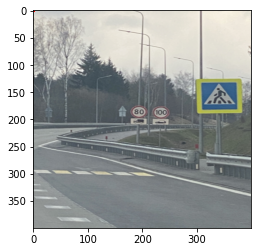

predicted_anchor_locs tf.Tensor(
[[[-0.15717286 -0.16255544 -0.1759487  -0.16786492]
  [-0.16790144 -0.1679123  -0.16787544 -0.16786486]
  [-0.1678705  -0.16785307 -0.16785401 -0.16784552]
  ...
  [-0.04537503 -0.04539315 -0.04541644 -0.04538837]
  [-0.04538586 -0.04538555 -0.04538447 -0.04538403]
  [-0.04535867 -0.04231419 -0.04697695  0.01361891]]], shape=(1, 10000, 4), dtype=float32)
anchor_locs_batch tf.Tensor(
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]], shape=(1, 10000, 4), dtype=float32)
iow roi tf.Tensor([783.4476], shape=(1,), dtype=float32)
iow rpn tf.Tensor([164.28058], shape=(1,), dtype=float32)
Epoch  0  Average Loss:  tf.Tensor(3.1291654, shape=(), dtype=float32)
Classification Accuracy:(ROI, RPN)  tf.Tensor(0.6, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
Bboxes Accuracy:(ROI, RPN)  tf.Tensor(783.4476, shape=(), dtype=float32) tf.Tensor(164.28058, shape=(), dtype=float32)


original bbox_coo

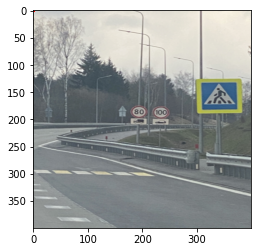

predicted_anchor_locs tf.Tensor(
[[[-0.08004367 -0.04816845 -0.06122902 -0.05305827]
  [-0.05309527 -0.05310646 -0.05306944 -0.05305886]
  [-0.05306436 -0.05304684 -0.0530479  -0.05303921]
  ...
  [ 0.04566726  0.04564859  0.04562441  0.04565163]
  [ 0.04565429  0.04565527  0.0456575   0.04565843]
  [ 0.04568314  0.04886138  0.04459662  0.07901315]]], shape=(1, 10000, 4), dtype=float32)
anchor_locs_batch tf.Tensor(
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]], shape=(1, 10000, 4), dtype=float32)
iow roi tf.Tensor([189.93983], shape=(1,), dtype=float32)
iow rpn tf.Tensor([193.52501], shape=(1,), dtype=float32)
Epoch  20  Average Loss:  tf.Tensor(3.036581, shape=(), dtype=float32)
Classification Accuracy:(ROI, RPN)  tf.Tensor(0.4, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
Bboxes Accuracy:(ROI, RPN)  tf.Tensor(189.93983, shape=(), dtype=float32) tf.Tensor(193.52501, shape=(), dtype=float32)




KeyboardInterrupt: ignored

In [73]:
# # Instantiate model
# model = TrafficSignModel()

# checkpoint_directory = "/content/gdrive/MyDrive/DLFinalProjectDataset/ckpt"
# counter = tf.Variable(1)
# checkpoint = tf.train.Checkpoint(optimizer1 = model.optimizer_with_decay, optimizer2 = model.optimizer_without_decay, model=model, counter = counter)
# manager = tf.train.CheckpointManager(checkpoint, checkpoint_directory, max_to_keep=5)
# checkpoint.restore(manager.latest_checkpoint)
# if manager.latest_checkpoint:
#   print("Restored from {}".format(manager.latest_checkpoint))
# else:
#   print("Initializing from scratch.")

# # Train and Test.
# print('\n Start Training:')
# for i in range(model.epochs):
#   epoch_average_loss = train(model, training_dataframe, i)
#   if(i == model.epochs):
#     acc_class_roi_sum, roi_acc_sum, acc_class_rpn_sum, rpn_acc_sum = test(model, testing_dataframe, True)
#     print('Training Completed')
#     print("Final Epoch Average Loss: ", epoch_average_loss)
#     print("Final Classification Accuracy:(ROI, RPN) ", acc_class_roi_sum, acc_class_rpn_sum)
#     print("Final Bboxes Accuracy:(ROI, RPN) ", roi_acc_sum, rpn_acc_sum)
#   elif (i % 20 == 0):
#     checkpoint.counter.assign_add(1)
#     manager.save()
#     acc_class_roi_sum, roi_acc_sum, acc_class_rpn_sum, rpn_acc_sum = test(model, testing_dataframe, False)
#     print("Epoch ", i, " Average Loss: ", epoch_average_loss)
#     print("Classification Accuracy:(ROI, RPN) ", acc_class_roi_sum, acc_class_rpn_sum)
#     print("Bboxes Accuracy:(ROI, RPN) ", roi_acc_sum, rpn_acc_sum)
#     print('\n')